In [1]:
from sympy import init_printing, Symbol, Matrix, simplify, lambdify, Array, diff, integrate
init_printing()

In [2]:
from sympy import Heaviside, symbols, Piecewise, plot, And, re

In [48]:
import numpy as np
import numpy.linalg as nla
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from scipy.integrate import quad
from numpy.polynomial.legendre import leggauss
plt.rc('text', usetex=True)
from jupyterthemes import jtplot  # this requires jupyterthemes to be installed
jtplot.style()

In [50]:
plt.rcParams['font.weight'] = 700
plt.rcParams['xtick.top']='True'
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.right']='True'
plt.rcParams['ytick.direction']='in'
plt.rcParams['ytick.labelsize']=22
plt.rcParams['xtick.labelsize']=22
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.minor.size']=3
plt.rcParams['ytick.major.size']=6
plt.rcParams['ytick.minor.size']=3
plt.rcParams['lines.markersize']=np.sqrt(36)
plt.rc('text',usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath,amsfonts,amssymb,bm}"]

## Problem 1 -- definite integration

Given equation
$$ \frac{d}{dx}\left( EA(x) \frac{du}{dx}\right) + b(x) = 0,\quad u(1) = u(5) = 0$$

where 
$$A(x) = \begin{cases} 0.1, & 1\leq x < 3 \\ 0.5(x-1), & 3 \leq x \leq 5\end{cases} $$ 

and $$ b(x) = \begin{cases}
10, & 1\leq x \leq 3, \\
0, & 3 < x \leq 5,
\end{cases} + \frac{P}{l_0}\delta\left({x-3}\right)
$$

Hint: use both the dirichlet boundaries for integration. One of them will lead to the solution of a constant of integration, i.e. 
$$ EA(x) \frac{du}{dx}(x) - EA(1)\frac{du}{dx}(1) = -\int_{1}^x b(\xi)d\xi$$
which implies 
$$ \frac{du}{dx} = -\frac{1}{EA(x)}\int_{1}^x b(\xi)d\xi + \frac{A(1)}{A(x)}c_1\qquad \because u'(1) = c_1$$
and
$$ u(x) = 
- \int_5^x \frac{1}{EA(r)}\left(\int_{1}^r b(\xi)d\xi\right) dr + c_1\int_5^x \frac{A(1)}{A(r)}dr
$$
Furthermore $u(1) = 0$, which gives
$$c_1 
= \dfrac{\displaystyle\int_5^1 \dfrac{1}{EA(r)}\left(\int_{1}^r b(\xi)d\xi\right) dr}{\displaystyle\int_5^1 \dfrac{A(1)}{A(r)}dr}
$$

In [5]:
xi = Symbol("xi", real=True)
x= Symbol("x", real=True)
r= Symbol("r", real=True)

In [20]:
Y = 2.e7
area = lambda x: Piecewise((0.1, x < 3), (0.5*(x - 1), x >= 3))
bodyForce = lambda x: Piecewise((10, x < 3), (0, x >= 3), (0, x <= 0))
innerIntegral = lambda r: simplify(integrate(bodyForce(xi), (xi, 1, r)) + 150*Heaviside(r-3,0))
c1 = simplify(integrate(1./(Y*area(r))*innerIntegral(r),(r,5,1))/integrate(0.1/area(r),(r,5,1)))
float(c1)

In [28]:
usol = simplify(-integrate(1./Y/area(r)*innerIntegral(r), (r, 5, x)) + float(c1)*integrate(0.1/area(r), (r, 5, x)) )
epsol = simplify(usol.diff(x))

In [29]:
epsol = lambdify(x, epsol, ["sympy"])
xv = np.linspace(1,5,100)
# Heaviside(0)

In [30]:
xv = np.linspace(1,5,101)

In [32]:
epslist = list(map(epsol, xv))

In [35]:
class basis(): # defined on the canonical (master) element (1D : [-1,1] ) 
    def __init__(self,deg,basis_type, Xi):
        deg = int(deg)
        if basis_type == 'L':          # 1D Lagrange basis of degree `deg`
            z=Symbol('z')
            def lag_basis(k):   #basically change this
                n = 1.
                for i in range(len(Xi)):
                    if k != i:
                        n *= (z-Xi[i])/(Xi[k]-Xi[i])
                return n
            N = Array([simplify(lag_basis(m)) for m in range(deg+1)])            
            dfN = diff(N,z)+1.e-25*N #for shape consistency
            self.Ns=lambdify(z, N, "numpy")
            self.dN=lambdify(z, dfN, "numpy")

# Element1 
Xi1 = np.linspace(1,3,3)
Xi2 = np.linspace(3,5,2)
Bquad = basis(2, "L", Xi1)
Blin = basis(1, "L", Xi2)

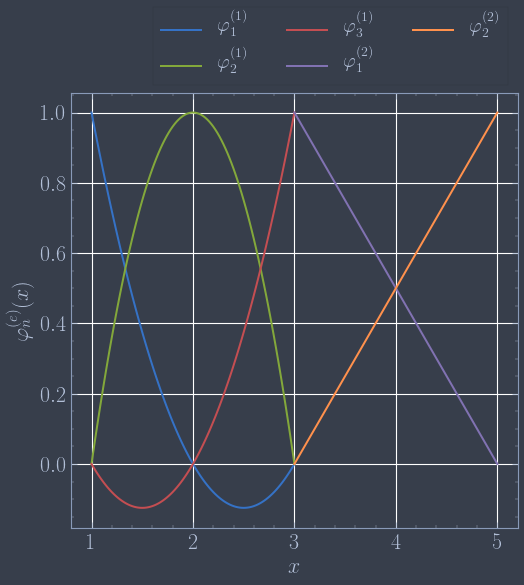

In [53]:
# Plot the basis functions
x1 = np.linspace(1, 3, 101)
x2 = np.linspace(3, 5, 101)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x1, Bquad.Ns(x1)[0], lw = 2, label=r"$\varphi^{(1)}_1$")
ax.plot(x1, Bquad.Ns(x1)[1], lw = 2, label=r"$\varphi^{(1)}_2$")
ax.plot(x1, Bquad.Ns(x1)[2], lw = 2, label=r"$\varphi^{(1)}_3$")
ax.plot(x2, Blin.Ns(x2)[0], lw = 2, label=r"$\varphi^{(2)}_1$")
ax.plot(x2, Blin.Ns(x2)[1], lw = 2, label=r"$\varphi^{(2)}_2$")
ax.legend(loc=0, ncol=3, fontsize=20, fancybox =False, edgecolor="k", bbox_to_anchor=(1,1.22))
ax.set_xlabel(r"$x$", fontsize=22)
ax.set_ylabel(r"$\varphi^{(e)}_n(x)$", fontsize=22)
ax.grid(which="major", color="w")

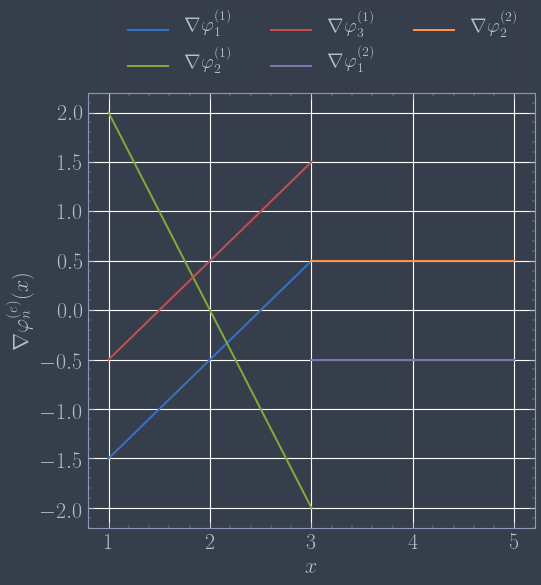

In [56]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x1, Bquad.dN(x1)[0], lw = 2, label=r"$\nabla\varphi^{(1)}_1$")
ax.plot(x1, Bquad.dN(x1)[1], lw = 2, label=r"$\nabla\varphi^{(1)}_2$")
ax.plot(x1, Bquad.dN(x1)[2], lw = 2, label=r"$\nabla\varphi^{(1)}_3$")
ax.plot(x2, Blin.dN(x2)[0], lw = 2, label=r"$\nabla\varphi^{(2)}_1$")
ax.plot(x2, Blin.dN(x2)[1], lw = 2, label=r"$\nabla\varphi^{(2)}_2$")
ax.legend(loc=0, ncol=3, fontsize=20, fancybox =False, edgecolor="k", bbox_to_anchor=(1,1.22))
ax.set_xlabel(r"$x$", fontsize=22)
ax.set_ylabel(r"$\nabla\varphi^{(e)}_n(x)$", fontsize=22)
ax.grid(which="major", color="w")

In [ ]:
# Galerkin FEM
kglob = np.zeros((2,2))
fglob = np.zeros(kglob.shape[0])

In [60]:
# Compute gausspoints and weights
ngp1, w1 = leggauss(2)
ngp0, w0 = leggauss(1)

array([0.])

In [72]:
area_num = lambdify(x, area(x), "numpy")
body_force_num = lambdify(x, bodyForce(x), "numpy")

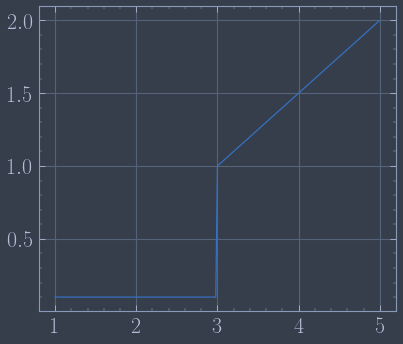

In [ ]:
xv = np.linspace(1.+1.e-9,5,100)
plt.figure(figsize=(8,8))
plt.plot(xv, list(map(usol, xv)),lw=3, label="Exact solution")
plt.legend(loc=0, fontsize=22, fancybox=False, shadow=True)
plt.grid(which="major", color="w")